In [274]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils.contours import sort_contours
import imutils
from tensorflow.keras.models import load_model

In [275]:
# --------------------------
# Loading the neural network
# --------------------------

network = load_model('custom_ocr.keras')
network.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 415,406 (1.58 MB)

 Trainable params: 138,468 (540.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 276,938 (1.06 MB)

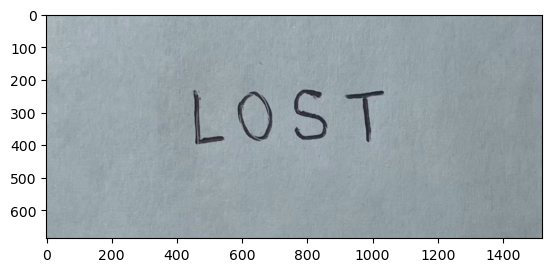

In [276]:
# ----------------------
# Loading the test image
# ----------------------

img = cv2.imread('lost.jpg')
plt.imshow(img)

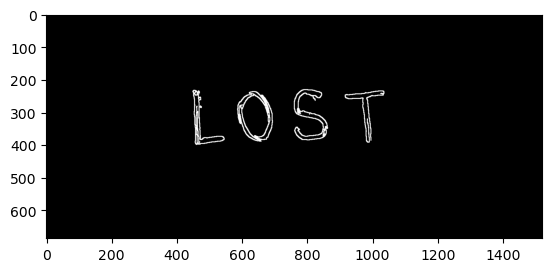

In [277]:
# ------------------------
# Pre-processing the image
# ------------------------

def preprocess_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 7)
    edges = cv2.Canny(blur, 40, 150)
    dilation = cv2.dilate(edges, np.ones((3,3)))  
    return gray, dilation

gray, processed_img = preprocess_img(img)
plt.imshow(processed_img, cmap="gray")

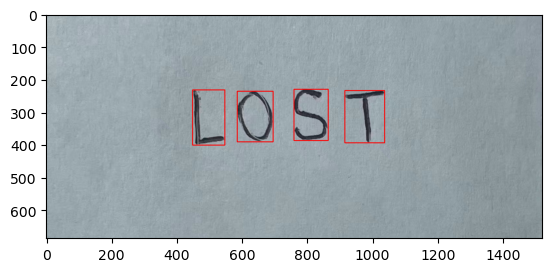

In [278]:
# -----------------
# Contour detection
# -----------------

# Retrieve only external contours (ignore nested ones) and return contours sorted from left to right
def find_contours(img):
    conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    conts = imutils.grab_contours(conts)
    conts = sort_contours(conts, method = 'left-to-right')[0]
    return conts

# Detect contours on the processed image
conts = find_contours(processed_img.copy())

# Define minimum and maximum width/height thresholds for valid bounding boxes (This helps filter out noise or large unwanted regions)
min_w, max_w = 4, 180
min_h, max_h = 14, 180
img_copy = img.copy()
for c in conts:
    (x, y, w, h) = cv2.boundingRect(c)
    # Keep only contours within the specified size range (possible characters)
    if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
        # Extract the region of interest (ROI) from the grayscale image
        roi = gray[y:y+h, x:x+w]
        # Apply thresholding again to make the ROI binary (foreground = white)
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1] 
        # Draw a bounding box around the detected contour on the copy image
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Display the image with all detected bounding boxes
plt.imshow(img_copy, cmap="gray")

In [279]:
# ----------------------------------
# Processing the detected characters
# ----------------------------------

# Extracts the region of interest (ROI) from the image with an optional margin
def extract_roi(img, margin=2):
    roi = img[y - margin:y + h, x - margin:x + w + margin]
    return roi

# Apply Otsu’s thresholding to automatically determine the optimal threshold and convert the image to binary (black & white)
def thresholding(img):
    thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    return thresh

# Resize the image to 28×28 pixels while maintaining aspect ratio (Add black padding to fill extra space)
def resize_img(img, w, h):
    if w > h:
        resized = imutils.resize(img, width = 28)
    else:
        resized = imutils.resize(img, height = 28)
    
    (h, w) = resized.shape
    dX = int(max(0, 28 - w) / 2.0)
    dY = int(max(0, 28 - h) / 2.0)
    # Add black borders to center the image within a 28×28 frame
    filled = cv2.copyMakeBorder(resized, top=dY, bottom=dY, right=dX, left=dX, borderType=cv2.BORDER_CONSTANT, value = (0,0,0))
    filled = cv2.resize(filled, (28,28))
    return filled

# Normalize image to [0,1] and add a channel dimension (28×28 → 28×28×1)
def normalization(img):
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis = -1)
    return img

print(test_img2.shape, normalization(test_img2).shape)

# Store tuples of (processed image, bounding box)
characters = []
def process_box(gray, x, y, w, h):
    roi = extract_roi(gray)
    thresh = thresholding(roi)
    (h, w) = thresh.shape
    resized = resize_img(thresh, w, h)
    normalized = normalization(resized)
    characters.append((normalized, (x, y, w, h)))

# Loop through all contours and process valid ones (within width/height range)
for c in conts:
    (x, y, w, h) = cv2.boundingRect(c)
    if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
        process_box(gray, x, y, w, h)

# Extract only the bounding boxes from processed characters
boxes = [box[1] for box in characters]
boxes

(28, 28) (28, 28, 1)


[(449, 232, 103, 171),
 (586, 236, 114, 157),
 (760, 230, 109, 159),
 (916, 234, 126, 162)]

In [280]:
# Convert all processed character images into a NumPy array
pixels = np.array([pixel[0] for pixel in characters], dtype = 'float32')
print(pixels[0].shape, pixels.shape)

(28, 28, 1) (4, 28, 28, 1)


In [281]:
# -------------------------
# Recognition of characters
# -------------------------

# Use the trained neural network to predict each character
# 'pixels' is the preprocessed batch of character images (N × 28 × 28 × 1)
predictions = network.predict(pixels)
print(predictions.shape)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
(4, 36)


array([[9.1072849e-23, 1.6491554e-09, 2.8000302e-10, 1.2635591e-28,
        9.9970097e-13, 3.0854671e-17, 2.0966298e-10, 1.9456975e-17,
        8.5311504e-17, 9.5604094e-33, 4.6306025e-15, 9.2254689e-16,
        1.9798936e-08, 6.2758582e-16, 2.4580746e-08, 5.5884425e-14,
        1.3851705e-12, 5.4957375e-11, 2.0881865e-16, 5.6268382e-11,
        5.1948069e-07, 9.9999893e-01, 2.7551240e-12, 1.0496404e-11,
        6.0075458e-13, 4.2431659e-11, 2.3411317e-15, 1.0375191e-10,
        2.2699934e-12, 3.7969158e-08, 7.6927109e-10, 6.7018822e-15,
        2.1597232e-08, 8.9830907e-11, 1.8151118e-10, 5.1239641e-07],
       [9.7610247e-01, 2.7415775e-10, 1.0428147e-10, 1.2092358e-11,
        3.7273594e-11, 2.3964164e-09, 2.0134969e-10, 6.0485386e-09,
        2.0701539e-10, 3.8338658e-07, 6.8520255e-12, 3.2776359e-10,
        2.2371944e-08, 3.9079092e-05, 3.5691580e-13, 3.8864993e-19,
        1.1203470e-09, 5.4030610e-18, 1.6427575e-17, 7.2985151e-10,
        1.5376060e-15, 2.6832159e-15, 2.5222307

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
L  ->  99.9998927116394
0  ->  97.61024713516235
S  ->  83.6523711681366
T  ->  94.43076848983765


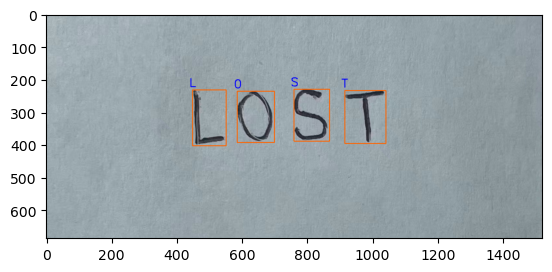

In [282]:
# Define the mapping between prediction indices and actual characters
digits = '0123456789'
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
characters_list = digits + letters
characters_list = [l for l in characters_list]
print(characters_list)

img_copy = img.copy()
# Loop over each predicted character and its bounding box
for (prediction, (x, y, w, h)) in zip(predictions, boxes):
    # Get index of the highest probability (predicted class)
    i = np.argmax(prediction)
    probability = prediction[i]
    character = characters_list[i]

    # Draw bounding box around detected character
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255,100,0), 2)
    # Annotate the predicted character above the box
    cv2.putText(img_copy, character, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,255), 2)
    print(character, ' -> ', probability * 100)

# Display the final annotated image showing recognized characters
plt.imshow(img_copy)